#                 ** Fake News Detection**
**Stance Detection is one of the factors influencing fake news detection. The goal of this project is to use natural language processing
techniques to automate stance detection.**
Stance detection is a method used to determine the quality of a
news article by taking into consideration what other
organisations write about the same headline. A body of text is
claimed to ***agree, disagree, discuss, or be unrelated.***
Here,we use two csv files named as **train_bodies.csv and train_stances.csv.**

In [ ]:
! pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from os import path
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import pylab as py
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
from tqdm import tqdm
from scipy import sparse
import csv, random, numpy, os, re, nltk, scipy, gensim
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from langdetect import detect
from sklearn.ensemble import RandomForestClassifier
from csv import DictReader
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
# import score

In [ ]:
class DataSet():
    def __init__(self, path="/content/drive/MyDrive/data"):
        self.path = path

        print("Reading dataset")
        bodies = "train_bodies.csv"
        stances = "train_stances.csv"

        self.stances = self.read(stances)
        articles = self.read(bodies)
        self.articles = dict()

        #make the body ID an integer value
        for s in self.stances:
            s['Body ID'] = int(s['Body ID'])

        #copy all bodies into a dictionary
        for article in articles:
            self.articles[int(article['Body ID'])] = article['articleBody']

        print("Total stances: " + str(len(self.stances)))
        print("Total bodies: " + str(len(self.articles)))



    def read(self,filename):
        rows = []
        with open(self.path + "/" + filename, "r", encoding='utf-8') as table:
            r = DictReader(table)

            for line in r:
                rows.append(line)
        return rows

In [ ]:
dataset = DataSet()

Reading dataset
Total stances: 49972
Total bodies: 1683


In [ ]:
dataset.stances[2]

OrderedDict([('Headline',
              "Christian Bale passes on role of Steve Jobs, actor reportedly felt he wasn't right for part"),
             ('Body ID', 137),
             ('Stance', 'unrelated')])

In [ ]:
dataset.articles[137]

'30-year-old Moscow resident was hospitalized with wounds very intimate nature. As it became known LifeNews, in the hands of doctors, the man complained that his casual acquaintance opoila in the sauna, and then gently held his castration operation. And actions criminals were executed with surgical precision - woman sewed all the smallest blood vessels.\n\n\n\n- I met a girl at the bar, and then we went to the sauna for a taxi. I remember that I had a beer, and more do not remember, - said Roman law enforcement officials.\n\nAt the hospital, the man hours spent in intensive care, doctors were forced to spend a second operation on the testicles.\n\n- I thought I had just cut, but at the hospital they told me that I removed the testicles - told Roman about his sad adventures.\n\n- The patient had literally jewelry operation - he cut out eggs and ligated vessels. We can say that the transactions were either physician or veterinarian - doctors say.\n\nInterestingly, the wife of the injured

**Pre-processing:** As part of pre-processing, I started
reading both csv data files. Then from the dataset,
randomly body ids were extracted and divided into
training, dev and test ids so that it can be used further
while training the model.


In [ ]:
def read_ids(file,base):
    ids = []
    with open(base+"/"+file,"r") as f:
        for line in f:
            ids.append(int(line))
        return ids

def split(dataset, base="/content/drive/MyDrive/data"):
    if not (os.path.exists(base+"/"+"training_ids.txt")
            and os.path.exists(base+"/"+"dev_ids.txt") and os.path.exists(base+"/"+"test_ids.txt")):
        raise Exception("There is an error and the dataset reader cannot find the "
                        "{training_ids|test_ids|dev_ids}.txt file. Please make sure your python paths "
                        "are configured correctly")

    training_ids = read_ids("training_ids.txt",base)
    dev_ids = read_ids("dev_ids.txt",base)
    test_ids = read_ids("test_ids.txt",base)

    #return the stances that meet these criteria
    training_stances = []
    dev_stances = []
    test_stances = []

    for stance in dataset.stances:
        if stance['Body ID'] in training_ids:
            training_stances.append(stance)
        elif stance['Body ID'] in dev_ids:
            dev_stances.append(stance)
        elif stance['Body ID'] in test_ids:
            test_stances.append(stance)


    return {"training":training_stances, "dev":dev_stances, "test": test_stances}

In [ ]:
print("\n[1] Loading data..")
data_splits = split(dataset)
# in the format: Stance, Headline, BodyID
training_data = data_splits['training']
dev_data = data_splits['dev']
test_data = data_splits['test'] # currently 0 test points

# Change the number of training examples used.
N = int(len(training_data) * 1.0)
training_data = training_data[:N]

print("\t-Training size:\t", len(training_data))
print("\t-Dev size:\t", len(dev_data))
print("\t-Test data:\t", len(test_data))


[1] Loading data..
	-Training size:	 40106
	-Dev size:	 4835
	-Test data:	 5031


In [ ]:
len(dataset.articles)

1683

In [ ]:
# Get the bodies of training data points
def get_bodies(data):
    bodies = []
    for i in range(len(data)):
        bodies.append(dataset.articles[data[i]['Body ID']])
    return bodies

In [ ]:
data

In [ ]:
# Get the headlines of training data points
def get_headlines(data):
    headlines = []
    for i in range(len(data)):
        headlines.append(data[i]['Headline'])
    return headlines

In [ ]:
# Get bodies and headlines for dev and training data
training_bodies = get_bodies(training_data)
training_headlines = get_headlines(training_data)
dev_bodies = get_bodies(dev_data)
dev_headlines = get_headlines(dev_data)
test_bodies = get_bodies(test_data)
test_headlines = get_headlines(test_data)

print(len(training_bodies))
print(len(training_headlines))
print(len(dev_bodies))
print(len(dev_headlines))
print(len(test_bodies))
print(len(test_headlines))

40106
40106
4835
4835
5031
5031


**tfidf Vectorization:** it is used to convert the text into feature vectors(ntg but numericals)

In [ ]:
# Function for extracting tf-idf(term frequency-inverse document frequenct) vectors (for both the bodies and the headlines).
# https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments

def extract_tfidf(training_headlines, training_bodies, dev_headlines="", dev_bodies="", test_headlines="", test_bodies=""):
    # Body vectorisation
    body_vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=True, stop_words='english')#, max_features=1024)
    bodies_tfidf = body_vectorizer.fit_transform(training_bodies)

    # Headline vectorisation
    headline_vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=True, stop_words='english')#, max_features=1024)
    headlines_tfidf = headline_vectorizer.fit_transform(training_headlines)

    # Tranform dev/test bodies and headlines using the trained vectorizer (trained on training data)
    bodies_tfidf_dev = body_vectorizer.transform(dev_bodies)
    headlines_tfidf_dev = headline_vectorizer.transform(dev_headlines)

    bodies_tfidf_test = body_vectorizer.transform(test_bodies)
    headlines_tfidf_test = headline_vectorizer.transform(test_headlines)

    feature_names = np.array(body_vectorizer.get_feature_names())
    sorted_by_idf = np.argsort(body_vectorizer.idf_)
    print('Features with lowest and highest idf in the body vector:\n')
    # The token which appears maximum times but it is also in all documents, has its idf the lowest
    print("Features with lowest idf:\n{}".format(
    feature_names[sorted_by_idf[:10]]))
    # The tokens can have the most idf weight because they are the only tokens that appear in one document only
    print("\nFeatures with highest idf:\n{}".format(
    feature_names[sorted_by_idf[-10:]]))

    # Combine body_tfdif with headline_tfidf for every data point.
    training_tfidf = scipy.sparse.hstack([bodies_tfidf, headlines_tfidf])
    dev_tfidf = scipy.sparse.hstack([bodies_tfidf_dev, headlines_tfidf_dev])
    test_tfidf = scipy.sparse.hstack([bodies_tfidf_test, headlines_tfidf_test])

    return training_tfidf, dev_tfidf, test_tfidf

## **nltk(Natural Language Tool Kit)**: it is a libray and we can download stop_words by importing it.

## **Lemmatization :**It takes a word and remove prefix and suffix of the word and returns the root word of it.

## **word_overlap** in the sense Preprocessing.

In [ ]:
lemmatizer = nltk.WordNetLemmatizer()

# Tokenisation, Normalisation, Capitalisation, Non-alphanumeric removal, Stemming-Lemmatization
def preprocess(string):
    # to lowercase, non-alphanumeric removal
    step1 = " ".join(re.findall(r'\w+', string, flags=re.UNICODE)).lower()
    step2 = [lemmatizer.lemmatize(t).lower() for t in nltk.word_tokenize(step1)]

    return step2

# Function for extracting word overlap
def extract_word_overlap(headlines, bodies):
    word_overlap = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        preprocess_headline = preprocess(headline)
        preprocess_body = preprocess(body)

        # Lenght of common words b/w body and headline / Length of all the words of body & headline
        features = len(set(preprocess_headline).intersection(preprocess_body)) / float(len(set(preprocess_headline).union(preprocess_body)))
        word_overlap.append(features)

        # Convert the list to a sparse matrix (in order to concatenate the cos sim with other features)
        word_overlap_sparse = scipy.sparse.coo_matrix(numpy.array(word_overlap))
    return word_overlap_sparse

# **Stop_Words: **The words which doesn't add much value to our sentence.

In [ ]:
# Function for extracting the cosine similarity between bodies and headlines.
def extract_cosine_similarity(headlines, bodies):
    vectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english')#, max_features=1024)

    cos_sim_features = []
    for i in range(0, len(bodies)):
        body_vs_headline = []
        body_vs_headline.append(bodies[i])
        body_vs_headline.append(headlines[i])
        tfidf = vectorizer.fit_transform(body_vs_headline)

        cosine_similarity = (tfidf * tfidf.T).A
        cos_sim_features.append(cosine_similarity[0][1])

    # Convert the list to a sparse matrix (in order to concatenate the cos sim with other features)
    cos_sim_array = scipy.sparse.coo_matrix(numpy.array(cos_sim_features))

    return cos_sim_array

In [ ]:
# Function for combining features of various types (lists, coo_matrix, np.array etc.)
def combine_features(tfidf_vectors, cosine_similarity, word_overlap):
    combined_features =  sparse.bmat([[tfidf_vectors, word_overlap.T, cosine_similarity.T]])
    return combined_features

In [ ]:
# Function for extracting features
# Feautres: 1) Word Overlap, 2) TF-IDF vectors, 3) Cosine similarity, 4) Word embeddings
def extract_features(train, dev, test):
# Get bodies and headlines for dev and training data
    training_bodies = get_bodies(training_data)
    training_headlines = get_headlines(training_data)
    dev_bodies = get_bodies(dev_data)
    dev_headlines = get_headlines(dev_data)
    test_bodies = get_bodies(test_data)
    test_headlines = get_headlines(test_data)

    # Extract tfidf vectors
    print("\t-Extracting tfidf vectors..")
    training_tfidf, dev_tfidf, test_tfidf = extract_tfidf(training_headlines, training_bodies, dev_headlines, dev_bodies, test_headlines, test_bodies)
    print("\t-Tfidf vectors extracted..")

    # Extract word overlap
    print("\t-Extracting word overlap..")
    training_overlap = extract_word_overlap(training_headlines, training_bodies)
    dev_overlap = extract_word_overlap(dev_headlines, dev_bodies)
    test_overlap = extract_word_overlap(test_headlines, test_bodies)
    print("\t-Word overlap extracted..")

#     # Extract cosine similarity between bodies and headlines.
    print("\t-Extracting cosine similarity..")
    training_cos = extract_cosine_similarity(training_headlines, training_bodies)
    dev_cos = extract_cosine_similarity(dev_headlines, dev_bodies)
    test_cos = extract_cosine_similarity(test_headlines, test_bodies)
    print("\t-Cosine similarity extracted..")

    # Combine the features
    training_features = combine_features(training_tfidf, training_cos, training_overlap)
    dev_features = combine_features(dev_tfidf, dev_cos, dev_overlap)
    test_features = combine_features(test_tfidf, test_cos, test_overlap)
    print("\t-Combined features returned..")

    return training_features, dev_features, test_features

In [ ]:
test_data

[OrderedDict([('Headline',
               'Vandals add rude paint job to $2.5m Bugatti (but luckily for the owner it all turned out to be a hoax)'),
              ('Body ID', 615),
              ('Stance', 'unrelated')]),
 OrderedDict([('Headline',
               'No, Robert Plant Didn’t Rip Up an $800 Million Contract'),
              ('Body ID', 295),
              ('Stance', 'agree')]),
 OrderedDict([('Headline', 'N. Korea’s Kim has leg injury but in control'),
              ('Body ID', 570),
              ('Stance', 'unrelated')]),
 OrderedDict([('Headline',
               'Who Is Michael Zehaf-Bibeau? Ottawa Shooter Suspect Identified By Canadian Officials '),
              ('Body ID', 1251),
              ('Stance', 'unrelated')]),
 OrderedDict([('Headline',
               "Taylor Lianne Chandler: Michael Phelps' Cougar Girlfriend Revealed?"),
              ('Body ID', 1337),
              ('Stance', 'unrelated')]),
 OrderedDict([('Headline',
               'Catholic Priest Dead 

In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.

True

In [ ]:
# Feature extraction
print("[2] Extracting features.. ")
# extract_features(training_data, dev_data, test_data)
training_features, dev_features, test_features = extract_features(training_data, dev_data, test_data)

[2] Extracting features.. 
	-Extracting tfidf vectors..
Features with lowest and highest idf in the body vector:

Features with lowest idf:
['said' 'told' 'people' 'according' 'year' 'time' 'news' 'just' 'new'
 'reports']

Features with highest idf:
['real problem' 'point videos' 'real renderings' 'screens used'
 'authenticity document' 'having salespeople' 'having surgery'
 'maintained price' 'authenticity looking' 'summaries']
	-Tfidf vectors extracted..
	-Extracting word overlap..


40106it [03:54, 170.95it/s]
4835it [00:18, 265.29it/s]
5031it [00:18, 268.76it/s]


	-Word overlap extracted..
	-Extracting cosine similarity..
	-Cosine similarity extracted..
	-Combined features returned..


In [ ]:
classes = ['agree', 'disagree', 'discuss', 'unrelated']

def report_score(test,pred,algo):
    #accuracy calculation
    accuracy = accuracy_score(test,pred)
    print('\n Accuracy_score for %s = %s \n'%(algo,accuracy))

    #confusion_matrix
    mat = confusion_matrix(test,pred)
    fig, ax = plt.subplots(figsize=(11,11))
    ax.set_title("Confusion Matrix for %s" %algo)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap="icefire",
                xticklabels=classes,yticklabels=classes,linewidths=.3, ax=ax)
    plt.xlabel('True label')
    plt.ylabel('Predicted label');

    #classification report
    cls = classification_report(test,pred, target_names=classes)
    print(cls)

In [ ]:
# Creating targets
targets_tr = [a['Stance'] for a in training_data]
targets_dev = [a['Stance'] for a in dev_data]
targets_test = [a['Stance'] for a in test_data]

In [ ]:
def change(f):
    if f == 'unrelated':
        return 0
    elif f == 'disagree':
        return 1
    elif f == 'discuss':
        return 2
    elif f == 'agree':
        return 3
    else:
        return 0

y = [change(x) for x in targets_tr]
y_test = [change(x) for x in targets_test]

In [ ]:
def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)

In [ ]:
test_features

<5031x204365 sparse matrix of type '<class 'numpy.float64'>'
	with 1171073 stored elements in COOrdinate format>

Here, We using Three models for finding accuracy of our prediction.
   
**Logistic Regression:**It is used to predict the probability of a binary(yes/No) event occuring.

[3] Fitting model..
	-Logistic Regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[4] Evaluating model..

 Accuracy_score for Logistic Regression = 0.9039952295766249 

              precision    recall  f1-score   support

       agree       0.51      0.55      0.53       324
    disagree       0.35      0.55      0.43        89
     discuss       0.83      0.83      0.83       997
   unrelated       0.99      0.97      0.98      3621

    accuracy                           0.90      5031
   macro avg       0.67      0.72      0.69      5031
weighted avg       0.91      0.90      0.91      5031

	-Done with Logistic Regression


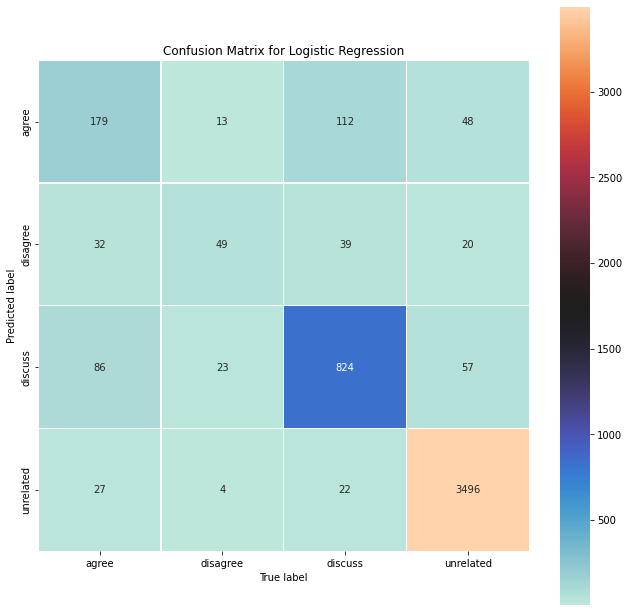

In [ ]:
# Fitting model
print("[3] Fitting model..")
print("\t-Logistic Regression")
lr = LogisticRegression(C = 1.0, class_weight='balanced', solver="lbfgs", max_iter=150)
y_pred_lr = lr.fit(training_features, targets_tr).predict(test_features)
# Evaluation
print("[4] Evaluating model..")
report_score(targets_test, y_pred_lr,'Logistic Regression')
print("\t-Done with Logistic Regression")

[3] Fitting model..
	-Random Forest Classifier
[4] Evaluating model..

 Accuracy_score for Random Forest Classifier = 0.8054064798250845 

              precision    recall  f1-score   support

       agree       0.27      0.37      0.31       324
    disagree       0.66      0.21      0.32        89
     discuss       0.62      0.80      0.70       997
   unrelated       0.95      0.86      0.90      3621

    accuracy                           0.81      5031
   macro avg       0.62      0.56      0.56      5031
weighted avg       0.84      0.81      0.81      5031

	-Done with Random Forest Classifier


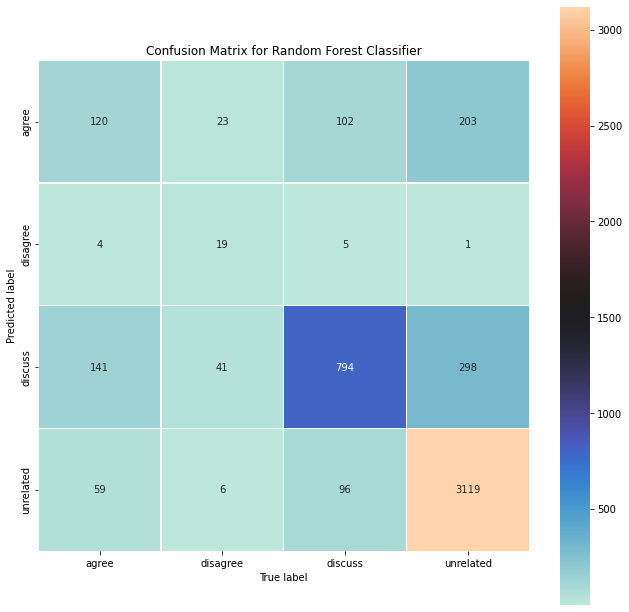

In [ ]:
print("[3] Fitting model..")
print("\t-Random Forest Classifier")
rf = RandomForestClassifier(n_estimators=10, random_state=12345)
y_pred_rf = rf.fit(training_features, targets_tr).predict(test_features)
# Evaluation
print("[4] Evaluating model..")
report_score(targets_test, y_pred_rf,'Random Forest Classifier')
print("\t-Done with Random Forest Classifier")

[3] Fitting model..
	-Multinomial Naive Bayes
[4] Evaluating model..

 Accuracy_score for Multinomial Naive Bayes = 0.4370900417412045 

              precision    recall  f1-score   support

       agree       0.13      0.43      0.20       324
    disagree       0.10      0.45      0.17        89
     discuss       0.34      0.71      0.46       997
   unrelated       0.88      0.36      0.51      3621

    accuracy                           0.44      5031
   macro avg       0.36      0.49      0.33      5031
weighted avg       0.71      0.44      0.48      5031

	-Done with Multinomial Naive Bayes


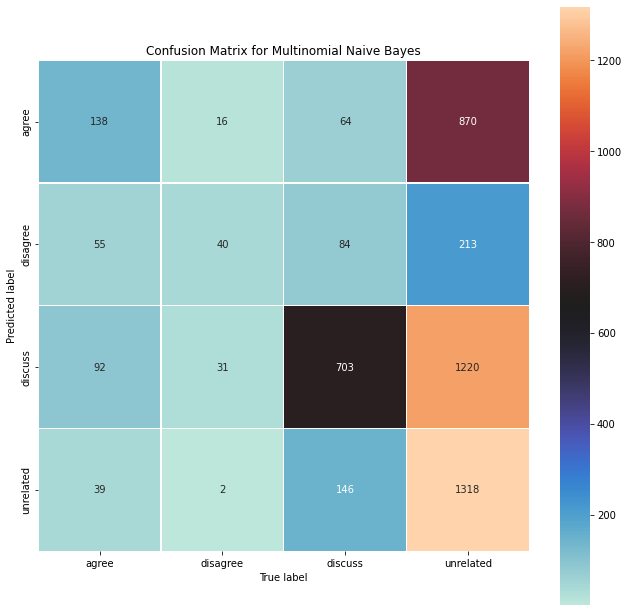

In [ ]:
print("[3] Fitting model..")
print("\t-Multinomial Naive Bayes")
nb = MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
y_pred_nb = nb.fit(training_features, targets_tr).predict(test_features)
# Evaluation
print("[4] Evaluating model..")
report_score(targets_test, y_pred_nb,'Multinomial Naive Bayes')
print("\t-Done with Multinomial Naive Bayes")

[3] Fitting model..
	-XGBoost Classifier
[4] Evaluating model..

 Accuracy_score for XGBoost = 0.4370900417412045 

              precision    recall  f1-score   support

       agree       0.13      0.43      0.20       324
    disagree       0.10      0.45      0.17        89
     discuss       0.34      0.71      0.46       997
   unrelated       0.88      0.36      0.51      3621

    accuracy                           0.44      5031
   macro avg       0.36      0.49      0.33      5031
weighted avg       0.71      0.44      0.48      5031

	-Done with XGBoost Classifier


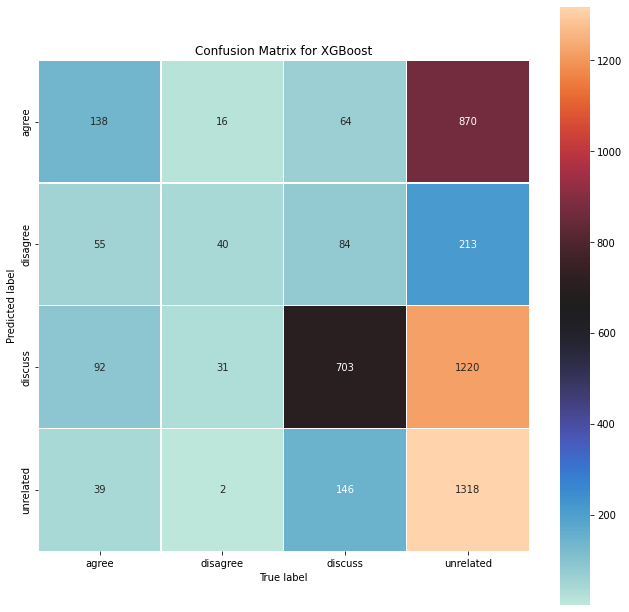

In [ ]:
print("[3] Fitting model..")
print("\t-XGBoost Classifier")
xgb = XGBClassifier()
y_pred_xgb = xgb.fit(training_features, targets_tr).predict(test_features)
# Evaluation
print("[4] Evaluating model..")
report_score(targets_test, y_pred_nb,'XGBoost')
print("\t-Done with XGBoost Classifier")

# Comparison of three models accuracy in one visualization.

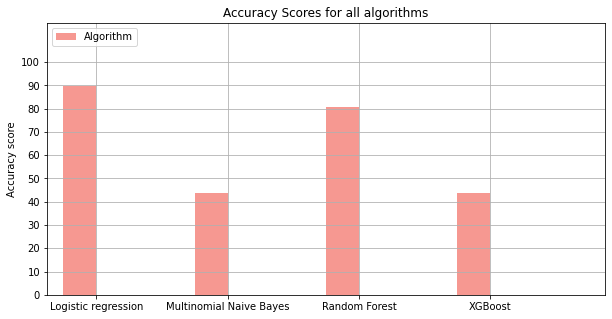

In [ ]:
width = 0.25


# IMPROVED_SYSTEM: Logistic, MNV, RF
score = [89.88, 43.71, 80.54, 43.70]

# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

pos = list(range(len(score)))

plt.bar(pos, score, width, alpha=0.5, color='#EE3224', label='Development set')

# Set the y axis label
ax.set_ylabel('Accuracy score')

# Set the chart's title
ax.set_title('Accuracy Scores for all algorithms')

# Set the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(['Logistic regression', 'Multinomial Naive Bayes', 'Random Forest', 'XGBoost'])
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])


plt.legend(['Algorithm'], loc='upper left')


plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(score)*1.3])

plt.grid()
plt.show()

On doing the above preprocessing, it was found that the data
took some time to process but then, on training the models, the
accuracy of some of them improved. It is found that Logistic
Regression is good performers with
almost 90% accuracy, to identify reliability of the source in
fake news detection.